In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord

### Reading in CDFS masterlist
Compiled metadata of all candidates, with crossmatch information for each candidate

In [44]:
# Reading in masterlist for a single field 
CDFS_mlist = pd.read_csv('masterlists/masterlist_CDFS.allccds_xmatch.csv')
masterlist = CDFS_mlist

In [3]:
masterlist

,CAND_ID,FIELD,CCD,RA_AVERAGE,DEC_AVERAGE,X_IMAGE,Y_IMAGE,MAG_PEAK_i,MAG_PEAK_g,MAG_PEAK_MJD,...,N_INFLECTIONS_g,LC_PATH,simbad_type,simbad_ctlg,simbad_sptype,simbad_redshift,gaia_DR3_parallax,gaia_DR3_parallaxerr,gaia_sigma,ps1_objID
0,29,CDFS,1,52.316104,-27.128169,400.64800,2197.86570,23.213,22.519,59629.03985,...,0,../../web/web/sniff/CDFS_tmpl/1/CDFS_1.20/CDFS...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,NaN,Unknown
1,66,CDFS,1,52.313504,-27.221706,434.39640,951.95825,23.407,23.6,59627.03400,...,1,../../web/web/sniff/CDFS_tmpl/1/CDFS_1.20/CDFS...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,NaN,0.11261
2,101,CDFS,1,52.311408,-27.137717,458.58385,2072.60605,23.262,NaN,59626.03692,...,0,../../web/web/sniff/CDFS_tmpl/1/CDFS_1.20/CDFS...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,NaN,Unknown
3,149,CDFS,1,52.308767,-27.128058,489.94440,2201.41775,22.921,NaN,59626.03692,...,0,../../web/web/sniff/CDFS_tmpl/1/CDFS_1.20/CDFS...,Galaxy,2dFGRS TGS243Z230,0.0686000,Unknown,Unknown,Unknown,NaN,1.96642
4,151,CDFS,1,52.308912,-27.257925,490.84250,469.53295,NaN,23.472,59629.03985,...,1,../../web/web/sniff/CDFS_tmpl/1/CDFS_1.20/CDFS...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,NaN,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15513,5977,CDFS,62,52.697692,-28.977439,4138.41185,1666.45330,23.366,NaN,59624.03615,...,0,../../web/web/sniff/CDFS_tmpl/62/CDFS_62.20/CD...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,NaN,0.093107
15514,5983,CDFS,62,52.697200,-28.950772,4145.12035,2022.68760,NaN,23.079,59632.03616,...,0,../../web/web/sniff/CDFS_tmpl/62/CDFS_62.20/CD...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,NaN,Unknown
15515,5993,CDFS,62,52.696525,-29.047189,4149.67260,737.96670,NaN,22.901,59632.03616,...,0,../../web/web/sniff/CDFS_tmpl/62/CDFS_62.20/CD...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,NaN,Unknown
15516,6123,CDFS,62,52.688167,-28.933417,4249.69535,2253.32250,22.897,NaN,59627.03400,...,0,../../web/web/sniff/CDFS_tmpl/62/CDFS_62.20/CD...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,NaN,0.144201


# Filtering Step 1: Crossmatching for stellarity and known variability
***
Check to see if a candidate is *known*, by crossmatching against multiple astronomical catalogs.  
Catalogs to be crossmatched, and requirements for candidate removal:  
* Gaia &nbsp;&nbsp; | &nbsp;&nbsp; Plx < 1.081  
* Legacy Survey &nbsp;&nbsp; | &nbsp;&nbsp; remove xmatches with type == 'PSF' (stellar objects)  
* Milliquas &nbsp;&nbsp; | &nbsp;&nbsp; remove xmatches with type == 'PSF' (stellar objects)  
* SIMBAD &nbsp;&nbsp; | &nbsp;&nbsp; remove anything not a galaxy or unknown
* Pan-STARRS &nbsp;&nbsp; | &nbsp;&nbsp; 

### Gaia crossmatch

In [4]:
masterlist['gaia_DR3_parallax'] = masterlist['gaia_DR3_parallax'].replace('Unknown',float(0.0))
masterlist["gaia_DR3_parallax"] = [float(x) for x in masterlist['gaia_DR3_parallax']]

In [5]:
print(f"Number of xmatches with Gaia: {len(masterlist[masterlist['gaia_DR3_parallax'] > 1.081])}")

Number of xmatches with Gaia: 328


In [6]:
mask_gaia = masterlist['gaia_DR3_parallax'] < 1.081

### Legacy Survey

In [7]:
# Keep everything without a xmatch, and that is NOT "PSF"

t_tr = masterlist
ra = np.array(t_tr['RA_AVERAGE'])
dec = np.array(t_tr['DEC_AVERAGE'])

filename = "ls/CDFS_ls_query_rad1.2.csv"
t_cat = pd.read_csv(filename)
ra_cat = np.array(t_cat['ra'][t_cat['type'] == 'PSF'])
dec_cat = np.array(t_cat['dec'][t_cat['type'] == 'PSF'])

# Create SkyCoord objects
transients = SkyCoord(ra=ra*u.degree, dec=dec*u.degree)
catalog = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree)

# Do the xmatch
idx, d2d, d3d = transients.match_to_catalog_sky(catalog)

# Condition on the 2D separation
max_sep = 1.5 * u.arcsec
sep_constraint = d2d < max_sep
transients_matches_ls = transients[sep_constraint]
catalog_matches_ls = catalog[idx[sep_constraint]]

In [8]:
print(f'Number of xmatches with Legacy Survey: {len(transients_matches_ls)}')

Number of xmatches with Legacy Survey: 959


In [9]:
transients_matches_ls = [(transients_matches_ls[i].ra.value, transients_matches_ls[i].dec.value) for i in np.arange(len(transients_matches_ls))]

In [10]:
transients_list_ls = [(transients[i].ra.value, transients[i].dec.value) for i in np.arange(len(transients))]
masterlist_notkeep_ls_idx = [i for i in np.arange(len(transients_list_ls)) if transients_list_ls[i] in transients_matches_ls]

In [11]:
mask_ls = ~masterlist.index.isin(masterlist_notkeep_ls_idx)

### Milliquas

In [12]:
filename = "milliquas/CDFS_milliquas_query_rad1.2.csv"
t_cat = pd.read_csv(filename)
ra_cat = np.array(t_cat['RAJ2000'])
dec_cat = np.array(t_cat['DEJ2000'])

# Create SkyCoord objects
catalog = SkyCoord(ra=ra_cat*u.degree, dec=dec_cat*u.degree)

# Do the xmatch
idx, d2d, d3d = transients.match_to_catalog_sky(catalog)

# Condition on the 2D separation
max_sep = 1.5 * u.arcsec
sep_constraint = d2d < max_sep
transients_matches_mqso = transients[sep_constraint]
catalog_matches_mqso = catalog[idx[sep_constraint]]

In [13]:
print(f'Number of xmatches with Milliquas: {len(transients_matches_mqso)}')

Number of xmatches with Milliquas: 74


In [14]:
transients_matches_mqso = [(transients_matches_mqso[i].ra.value, transients_matches_mqso[i].dec.value) for i in np.arange(len(transients_matches_mqso))]

In [15]:
transients_list_mqso = [(transients[i].ra.value, transients[i].dec.value) for i in np.arange(len(transients))]
masterlist_notkeep_mqso_idx = [i for i in np.arange(len(transients_list_mqso)) if transients_list_mqso[i] in transients_matches_mqso]

In [16]:
mask_mqso = ~masterlist.index.isin(masterlist_notkeep_mqso_idx)

### SIMBAD

In [17]:
masterlist['simbad_type'].unique()

array(['Unknown', 'Galaxy', 'Unknown_Candidate', 'EmG', 'Star',
       'AGN_Candidate', 'Radio', 'AGN', 'Radio(sub-mm)', 'QSO', 'SN',
       'GinCl', 'IG', 'EB*', 'EB*_Candidate', 'WD*_Candidate', 'ClG', 'X',
       'PM*', 'Seyfert_2', 'GroupG', 'QSO_Candidate', 'V*'], dtype=object)

In [18]:
list_simbad_galaxies = [
        "galaxy",
        "Galaxy",
        "EmG",
        "Seyfert",
        "Seyfert_1",
        "Seyfert_2",
        "BlueCompG",
        "StarburstG",
        "LSB_G",
        "HII_G",
        "High_z_G",
        "GinPair",
        "GinGroup",
        "BClG",
        "GinCl",
        "PartofG",
        "Compact_Gr_G",
        "IG",
        "PairG",
        "GroupG",
        "ClG",
        "SuperClG",
        "Void",
    ]

cds = [
    "Unknown",
    "Fail",
    "Fail 504",
] + list_simbad_galaxies

In [19]:
print(f"Number of xmatches with SIMBAD: {len(masterlist[~masterlist['simbad_type'].isin(cds)])}")

Number of xmatches with SIMBAD: 439


In [20]:
mask_simbad = masterlist['simbad_type'].isin(cds)

## Combining xmatch masks

In [21]:
# masks include candidates to *keep*
masterlist_clean = masterlist[mask_gaia & mask_ls & mask_simbad]

In [22]:
print(f'Number of candidates remaining after all xmatching: {len(masterlist_clean)}')

Number of candidates remaining after all xmatching: 14014


# Filtering Step 2: Number of detections
***
Checking to see if the candidate is *real* .  
This is checked by requiring more than two detections in the candidate unforced photometry light curve.

In [23]:
masterlist_clean.keys()

Index(['CAND_ID', 'FIELD', 'CCD', 'RA_AVERAGE', 'DEC_AVERAGE', 'X_IMAGE',
       'Y_IMAGE', 'MAG_PEAK_i', 'MAG_PEAK_g', 'MAG_PEAK_MJD', 'MAG_FAINT_i',
       'MAG_FAINT_g', 'MAG_FAINT_MJD', 'FIRST_DET', 'LAST_DET', 'FIRST_DET_i',
       'LAST_DET_i', 'FIRST_DET_g', 'LAST_DET_g', 'TMPL_STAR_CHECK',
       'N_DETECTIONS', 'N_GOOD_DETECTIONS', 'N_CONSECUTIVE_DETECTIONS_i',
       'N_CONSECUTIVE_DETECTIONS_i_1h', 'N_CONSECUTIVE_DETECTIONS_g',
       'N_CONSECUTIVE_DETECTIONS_g_1h', 'N_CONSECUTIVE_DETECTIONS_ig',
       'N_CONSECUTIVE_DETECTIONS_ig_1h', 'N_CONSECUTIVE_DETECTIONS_ig_2h',
       'RATE_i', 'RATE_g', 'RISE_i', 'FADE_i', 'RISE_g', 'FADE_g',
       'N_INFLECTIONS_i', 'N_INFLECTIONS_g', 'LC_PATH', 'simbad_type',
       'simbad_ctlg', 'simbad_sptype', 'simbad_redshift', 'gaia_DR3_parallax',
       'gaia_DR3_parallaxerr', 'gaia_sigma', 'ps1_objID'],
      dtype='object')

In [24]:
masterlist_numdets = masterlist_clean[masterlist_clean['N_DETECTIONS'] >= 3]

In [25]:
print(f'From Filtering steps 1 and 2, we reduced {len(masterlist)} candidates in a single field (CDFS) \
to {len(masterlist_numdets)} candidates ({np.round((len(masterlist_numdets)/len(masterlist))*100,2)}% remaining)')

From Filtering steps 1 and 2, we reduced 15518 candidates in a single field (CDFS) to 3609 candidates (23.26% remaining)


# Filtering Step 3:  Removing first night detections
***
Candidates with a detection on the first night of observations are removed, to ensure that our source is new. 

In [26]:
# Cutting candidates which have a detection within the first night
masterlist_firstdet_cut = masterlist_numdets[masterlist_numdets['FIRST_DET'] > np.min(masterlist_numdets['FIRST_DET']) + 0.9]
masterlist_firstdet_cut[['RA_AVERAGE','DEC_AVERAGE','FIRST_DET','LAST_DET','FIRST_DET_i','LAST_DET_i', 'FIRST_DET_g', 'LAST_DET_g']]

,RA_AVERAGE,DEC_AVERAGE,FIRST_DET,LAST_DET,FIRST_DET_i,LAST_DET_i,FIRST_DET_g,LAST_DET_g
1,52.313504,-27.221706,59624.04273,59627.03400,59627.03400,59627.03400,59624.04273,59626.04348
5,52.308242,-27.213417,59627.03400,59631.03192,59627.03400,59631.03192,NaN,NaN
8,52.302917,-27.131169,59626.03692,59631.03192,59626.03692,59631.03192,59630.03939,59630.03939
9,52.302233,-27.127964,59624.03615,59631.03192,59624.03615,59631.03192,NaN,NaN
10,52.302229,-27.171397,59627.03400,59631.03192,59627.03400,59631.03192,NaN,NaN
...,...,...,...,...,...,...,...,...
15476,52.788875,-29.060597,59625.03655,59631.03850,59625.03655,59630.03283,59626.04348,59631.03850
15482,52.779821,-29.071989,59625.03655,59629.03329,59625.03655,59629.03329,NaN,NaN
15487,52.773525,-29.076603,59630.03939,59632.03616,NaN,NaN,59630.03939,59632.03616
15510,52.711296,-29.017006,59624.03615,59629.03329,59624.03615,59629.03329,NaN,NaN


In [27]:
print(f'From Filtering steps 1 to 3, we reduced {len(masterlist)} candidates in a single field (CDFS) \
to {len(masterlist_firstdet_cut)} candidates ({np.round((len(masterlist_firstdet_cut)/len(masterlist))*100,2)}% remaining)')

From Filtering steps 1 to 3, we reduced 15518 candidates in a single field (CDFS) to 3164 candidates (20.39% remaining)


# Filtering Step 4: Removing  candidates near CCD edge

### Plotting coordinates of remaining candidates 

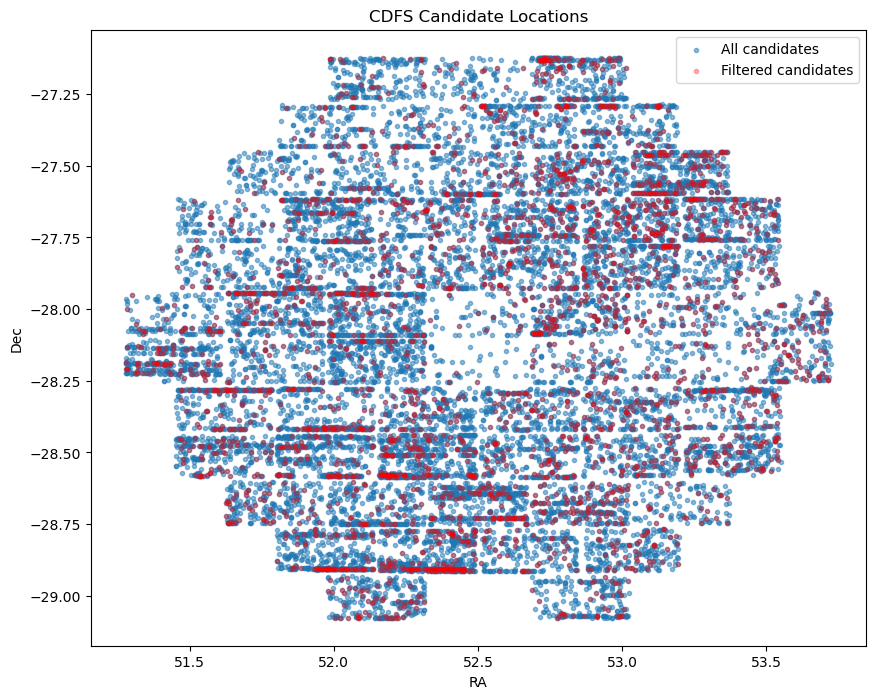

In [28]:
# Plotting locations of filtered candidates in CDFS on the DECam mosaic in RA and Dec
plt.figure(figsize=(10,8))
plt.scatter(masterlist['RA_AVERAGE'], masterlist['DEC_AVERAGE'], alpha=0.5, marker='.', label='All candidates')
plt.scatter(masterlist_firstdet_cut['RA_AVERAGE'], masterlist_firstdet_cut['DEC_AVERAGE'], alpha=0.3, marker='.',c='r', label='Filtered candidates')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('CDFS Candidate Locations')
plt.legend()
plt.savefig('CDFS_basicfiltering_candidate_mosaic.png')
plt.show()

Number of filtered candidates in CDFS CCD 57: 143


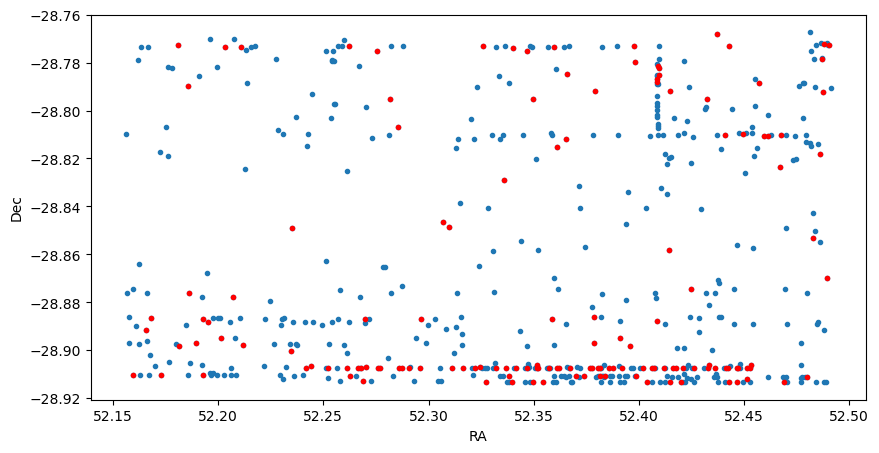

In [29]:
# Plotting only CCD 57
masterlist_ccd57 = masterlist[masterlist['CCD'] == 57]
masterlist_firstdet_cut_ccd57 = masterlist_firstdet_cut[masterlist_firstdet_cut['CCD'] == 57]
print(f'Number of filtered candidates in CDFS CCD 57: {len(masterlist_firstdet_cut_ccd57)}')
plt.figure(figsize=(10,5))
plt.scatter(masterlist_ccd57['RA_AVERAGE'], masterlist_ccd57['DEC_AVERAGE'], marker='.')
plt.scatter(masterlist_firstdet_cut_ccd57['RA_AVERAGE'], masterlist_firstdet_cut_ccd57['DEC_AVERAGE'], marker='.', c='r')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

In [39]:
# plot locations of nans
masterlist_xynans = masterlist_firstdet_cut[masterlist_firstdet_cut['X_IMAGE'].isnull()]
print(len(masterlist_xynans),'candidates with NaN pixel coordinates')

53 candidates with NaN pixel coordinates


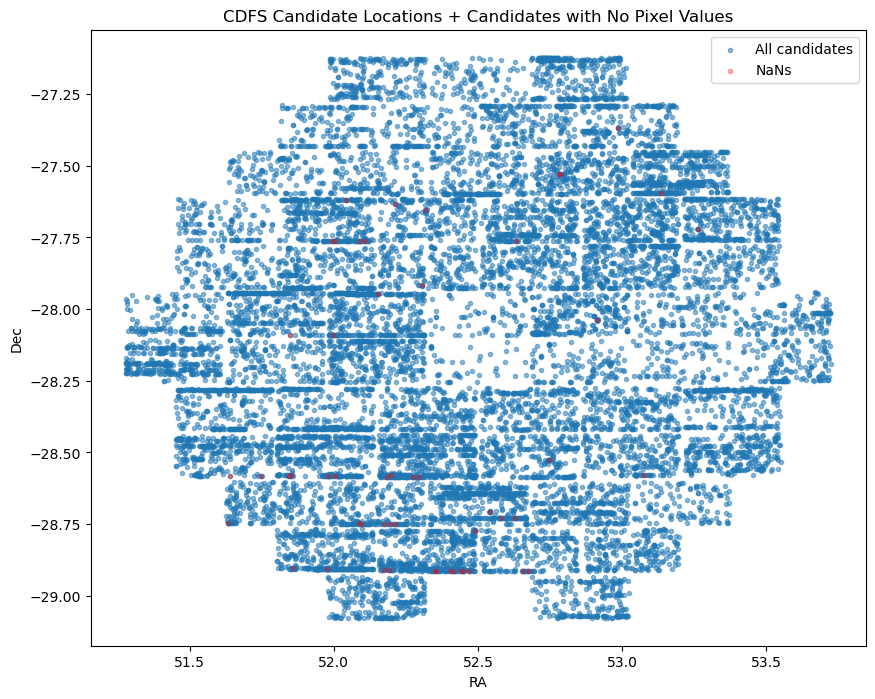

In [32]:
plt.figure(figsize=(10,8))
plt.scatter(masterlist['RA_AVERAGE'], masterlist['DEC_AVERAGE'], alpha=0.5, marker='.', label='All candidates')
plt.scatter(masterlist_xynans['RA_AVERAGE'], masterlist_xynans['DEC_AVERAGE'], alpha=0.3, marker='.',c='r', label='NaNs')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('CDFS Candidate Locations + Candidates with No Pixel Values')
plt.legend()
plt.show()

In [33]:
# Masking candidates within a certain number of pixels to a CCD edge
ccds = masterlist_firstdet_cut['CCD'].unique()
edge_cut = 20 # pixels -- look at a "bad" night, judge the FWHM from that
masterlist_edgecut = masterlist_firstdet_cut

for ccd in ccds:
    masterlist_singleccd = masterlist_edgecut[masterlist_edgecut['CCD'] == ccd]
    
    mask_edgecut = masterlist_singleccd[(masterlist_singleccd['X_IMAGE'] < np.min(masterlist_singleccd['X_IMAGE']) + edge_cut) |
                                        (masterlist_singleccd['X_IMAGE'] > np.max(masterlist_singleccd['X_IMAGE']) - edge_cut) |
                                        (masterlist_singleccd['Y_IMAGE'] < np.min(masterlist_singleccd['Y_IMAGE']) + edge_cut) |
                                        (masterlist_singleccd['Y_IMAGE'] > np.max(masterlist_singleccd['Y_IMAGE']) - edge_cut)]
    
    masterlist_edgecut = pd.concat([masterlist_edgecut,mask_edgecut]).drop_duplicates(keep=False)

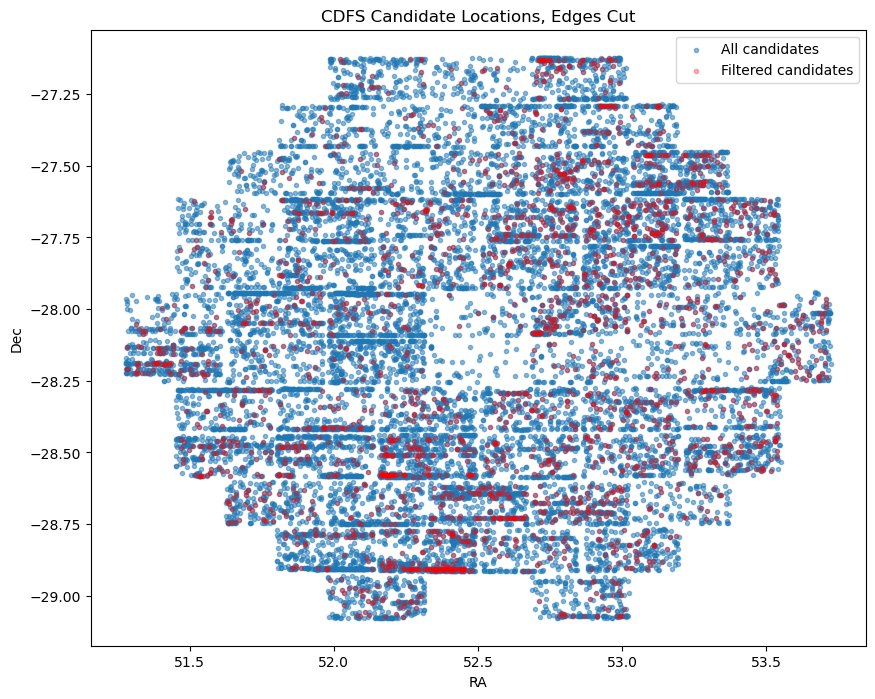

In [43]:
# Plotting locations of filtered candidates in CDFS on the DECam mosaic in RA and Dec
plt.figure(figsize=(10,8))
plt.scatter(masterlist['RA_AVERAGE'], masterlist['DEC_AVERAGE'], alpha=0.5, marker='.', label='All candidates')
plt.scatter(masterlist_edgecut['RA_AVERAGE'], masterlist_edgecut['DEC_AVERAGE'], alpha=0.3, marker='.',c='r', label='Filtered candidates')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.title('CDFS Candidate Locations, Edges Cut')
plt.legend()
plt.show()

In [35]:
# Save new masterlist with all basic filtering applied
masterlist_edgecut.to_csv('KNTraP_basic_filtering_CDFS_masterlist.csv')

In [36]:
print(f'From all basic filtering, we reduced {len(masterlist)} candidates in a single field (CDFS) \
to {len(masterlist_edgecut)} candidates ({np.round((len(masterlist_edgecut)/len(masterlist))*100,2)}% remaining)')

From all basic filtering, we reduced 15518 candidates in a single field (CDFS) to 2412 candidates (15.54% remaining)


### Further Plots

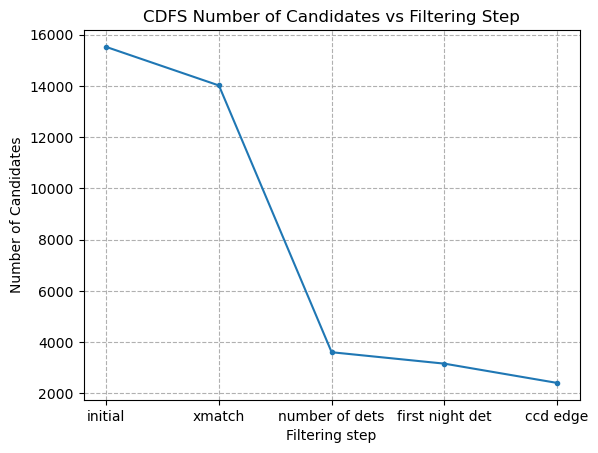

In [37]:
CDFS_filtered_arr = np.array([len(masterlist), len(masterlist_clean), len(masterlist_numdets), len(masterlist_firstdet_cut), len(masterlist_edgecut)])
filteringsteps_arr = ['initial', 'xmatch', 'number of dets', 'first night det', 'ccd edge']

plt.plot(filteringsteps_arr, CDFS_filtered_arr, marker='.')
plt.title('CDFS Number of Candidates vs Filtering Step')
plt.ylabel('Number of Candidates')
plt.xlabel('Filtering step')
plt.grid(linestyle = '--')
# plt.yscale('log')
plt.savefig('reducedcandidates_CDFS.png')